In [21]:
import torch
# 检查是否有可用的GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [22]:
import pandas as pd
import numpy as np
import os
import torch
from torch import nn
from skorch import NeuralNetRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

output_nums=1


# 修改后的createXY函数
def createXY(dataset: pd.DataFrame, n_past: int, n_future: int, column_target: str):
    dataX, dataY = [], []
    for i in range(n_past, len(dataset) - n_future + 1):
        dataX.append(dataset.iloc[i - n_past:i].values)
        dataY.append(dataset.iloc[i:i + n_future][column_target].values)
    return np.array(dataX), np.array(dataY)

# 修改后的process_files函数
def process_files(columns_all, column_target, folder_path, n_past=1, n_future=1):
    all_dataX, all_dataY = np.array([]), np.array([])
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path):
            series = pd.read_csv(file_path)
            single_dataset = series[columns_all]
            dataX, dataY = createXY(single_dataset, n_past, n_future, column_target)
            all_dataX = np.vstack([all_dataX, dataX]) if all_dataX.size else dataX
            all_dataY = np.vstack([all_dataY, dataY]) if all_dataY.size else dataY
    return all_dataX, all_dataY

# 'carbohydrate','protein','fat','cellulose'
columns_all = ['CGM (mg / dl)','CSII - basal insulin (Novolin R, IU / H)','carbohydrate','protein','fat','cellulose']
# columns_all = ['CGM (mg / dl)','CSII - basal insulin (Novolin R, IU / H)']
column_target = ['CGM (mg / dl)']
folder_path = './diabetes_datasets/T1'

# 使用n_past=8, n_future=4调用process_files
n_past=8
dataX, dataY = process_files(columns_all, column_target, folder_path, n_past=n_past, n_future=output_nums)



In [23]:
dataX.shape

(15567, 8, 6)

In [24]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch import nn, optim
from torch.utils.data import Subset

# 假设dataX和dataY是你的数据
# 将它们转换为PyTorch张量，这里假设它们已经是Tensor或者从Numpy转换过来的
dataX_tensor = torch.tensor(dataX, dtype=torch.float32)
dataY_tensor = torch.tensor(dataY, dtype=torch.float32)

# 创建TensorDataset对象
dataset = TensorDataset(dataX_tensor, dataY_tensor)

# 其余拆分数据集、创建DataLoader对象的代码与之前相同
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - (train_size + val_size)


# # 随机拆分数据集
# train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

assert train_size + val_size + test_size == len(dataset)
# 按照顺序划分数据集
train_dataset = Subset(dataset, range(0, train_size))
val_dataset = Subset(dataset, range(train_size, train_size + val_size))
test_dataset = Subset(dataset, range(train_size + val_size, len(dataset)))


batch_size = 64
# 创建DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
feature_nums = dataX.shape[2]


In [25]:
# import torch  
# import torch.nn as nn  
# import math  
  
# class PositionalEncoding(nn.Module):  
#     def __init__(self, d_model, max_len=5000):  
#         super(PositionalEncoding, self).__init__()  
  
#         # Compute the positional encodings once in log space.  
#         pe = torch.zeros(max_len, d_model)  
#         position = torch.arange(0, max_len).unsqueeze(1).float()  
#         div_term = torch.exp(torch.arange(0, d_model, 2) *  
#                              -(math.log(10000.0) / d_model))  
#         pe[:, 0::2] = torch.sin(position * div_term)  
#         pe[:, 1::2] = torch.cos(position * div_term)  
#         pe = pe.unsqueeze(0)  
#         self.register_buffer('pe', pe)  
  
#     def forward(self, x):  
#         x = x + self.pe[:, :x.size(1)]  
#         return x






# class TransformerEncoderModel(nn.Module):
#     def __init__(self,input_size=feature_nums,d_model=6,output_size=output_nums,seq_len=n_past):
#         super(TransformerEncoderModel, self).__init__()
#         self.input_size=input_size
#         self.d_model=d_model
#         self.output_size=output_size
#         self.seq_len=seq_len
#         # embed_dim = head_dim * num_heads?
#         self.input_fc = nn.Linear(self.input_size, self.d_model)
#         self.output_fc = nn.Linear(self.input_size, self.output_size)
#         self.pos_emb = PositionalEncoding(self.d_model)
#         encoder_layer = nn.TransformerEncoderLayer(
#             d_model=self.d_model,
#             nhead=8,
#             dim_feedforward=4 * self.d_model,
#             batch_first=True,
#             dropout=0.1,
#             device=device
#         )
#         decoder_layer = nn.TransformerDecoderLayer(
#             d_model=self.d_model,
#             nhead=8,
#             dropout=0.1,
#             dim_feedforward=4 * self.d_model,
#             batch_first=True,
#             device=device
#         )
#         self.encoder = torch.nn.TransformerEncoder(encoder_layer, num_layers=5)
#         self.decoder = torch.nn.TransformerDecoder(decoder_layer, num_layers=5)
#         self.fc = nn.Linear(self.output_size * self.d_model, self.output_size)
#         self.fc1 = nn.Linear(self.seq_len * self.d_model, self.d_model)
#         self.fc2 = nn.Linear(self.d_model, self.output_size)

#     def forward(self, x):
#         # print(x.size())  # (256, 24, 7)
#         y = x[:, -self.output_size:, :]
#         x = self.input_fc(x)  # (256, 24, 128)
#         x = self.pos_emb(x)   # (256, 24, 128)
#         x = self.encoder(x)
#         # 不经过解码器
#         x = x.flatten(start_dim=1)
#         x = self.fc1(x)
#         out = self.fc2(x)

#         return out


class TransformerEncoderModel(nn.Module):
    def __init__(self, input_dim=feature_nums, output_dim=output_nums, d_model=4, nhead=2, num_encoder_layers=1, dropout=0.2):
        super(TransformerEncoderModel, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.d_model = d_model
        self.nhead = nhead
        self.num_encoder_layers = num_encoder_layers
        
        # 使用线性层代替嵌入层
        self.linear_input = nn.Linear(self.input_dim, self.d_model)

        # 多头自注意力层
        encoder_layers = nn.TransformerEncoderLayer(d_model=self.d_model, nhead=self.nhead, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=self.num_encoder_layers)

        # 输出层
        self.linear_out = nn.Linear(self.d_model, self.output_dim)

    def forward(self, x):
        # 通过线性层
        x = self.linear_input(x)

        # 通过Transformer编码器
        x = self.transformer_encoder(x)

        # 取最后一个时间步的输出
        x = x[:, -1, :]

        # 通过输出层
        x = self.linear_out(x)

        return x

In [26]:
model = TransformerEncoderModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 早停法参数
best_val_loss = float('inf')
patience = 10
patience_counter = 0
max_epochs = 5000

for epoch in range(max_epochs):
    train_loss = 0
    model.train()
    
    # Training loop
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        target = target.squeeze(-1)  # 调整目标尺寸
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    # 每个epoch后，在验证集上评估模型
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            target = target.squeeze(-1)  # 调整目标尺寸
            output = model(data)
            val_loss += criterion(output, target).item()
    
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)

    print(f'Epoch {epoch}: Training Loss: {train_loss}, Validation Loss: {val_loss}')

    # 早停法逻辑
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # 保存最好的模型状态
        best_model_state = model.state_dict()
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f'Early stopping triggered after {epoch} epochs.')
        model.load_state_dict(best_model_state)
        break



Epoch 0: Training Loss: 31954.556470061, Validation Loss: 28901.344606983417
Epoch 1: Training Loss: 31515.898940831015, Validation Loss: 28411.850745376276
Epoch 2: Training Loss: 30893.931337957514, Validation Loss: 27742.69528260523
Epoch 3: Training Loss: 30055.86618585456, Validation Loss: 26837.535604671557
Epoch 4: Training Loss: 28978.72603074165, Validation Loss: 25739.26665636958
Epoch 5: Training Loss: 27724.61002130378, Validation Loss: 24502.419284119896
Epoch 6: Training Loss: 26343.70595184744, Validation Loss: 23163.105349170917
Epoch 7: Training Loss: 24871.47899470917, Validation Loss: 21760.69381776148
Epoch 8: Training Loss: 23339.328947302412, Validation Loss: 20317.892573142537
Epoch 9: Training Loss: 21772.948978789864, Validation Loss: 18862.594748983578
Epoch 10: Training Loss: 20201.35250561858, Validation Loss: 17419.307654555963
Epoch 11: Training Loss: 18648.168980428618, Validation Loss: 16010.05270448023
Epoch 12: Training Loss: 17135.408528576158, Valida

In [27]:
# 加载最佳模型状态
model.load_state_dict(best_model_state)

# 在测试集上验证模型并输出预测标签
model.eval()
test_loss = 0
all_predictions = []
all_targets = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        target = target.squeeze(-1)  # 调整目标尺寸
        output = model(data)
        test_loss += criterion(output, target).item()
        all_predictions.append(output.cpu().numpy())
        all_targets.append(target.cpu().numpy())

test_loss /= len(test_loader)
print(f'Test Loss: {test_loss}')

# 将预测标签和真实标签拼接成一个数组
all_predictions = np.concatenate(all_predictions, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

all_predictions = all_predictions.reshape(-1)
all_targets = all_targets.reshape(-1)
all_predictions.shape, all_targets.shape


Test Loss: 124.32740262089943


((3114,), (3114,))

In [ ]:
import torch

# 保存模型的状态字典到文件
torch.save(model.state_dict(), './model/transformerEncoder.pth')


### 取了最后1000个，可以取最后500-1000个观察一下，我这里发现是在峰值和低谷的时候预测都会差一点，是不是要考虑时间特征，这个我做个case study研究研究。

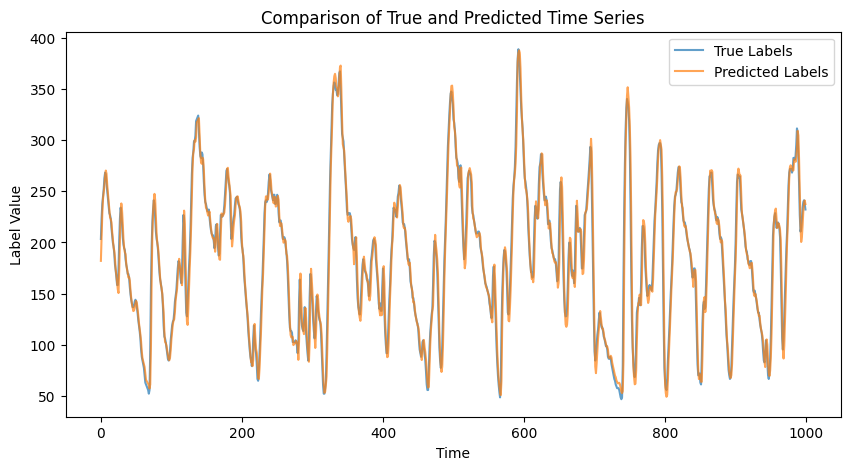

In [28]:
import matplotlib.pyplot as plt

# 画出比对图
plt.figure(figsize=(10, 5))
plt.plot(all_targets[-1000:], label='True Labels', alpha=0.7)
plt.plot(all_predictions[-1000:], label='Predicted Labels', alpha=0.7)
plt.legend()
plt.title('Comparison of True and Predicted Time Series')
plt.xlabel('Time')
plt.ylabel('Label Value')
plt.show()

In [29]:
targets_case=all_targets[-1000:]
predictions_case=all_predictions[-1000:]

# 找到同一位置，两者相差50以上的targets_case的值与位置
indexs = []
for i in range(len(targets_case)):
    if abs(targets_case[i]-predictions_case[i])>40:
        indexs.append(i)
        print(i,targets_case[i],predictions_case[i])


71 156.6 99.83772
296 145.8 103.32228
568 113.4 64.80153
650 221.4 180.55196
673 212.4 170.8763
741 163.8 84.51353
742 230.4 173.77393
751 237.6 282.7723
752 172.8 226.15913
797 174.6 222.08904
798 118.8 160.34897
